## Assignment 5

In this assignment the 20 newsgroup dataset is used.  
There are around 18000 posts on 20 different topicks. The data are also split in train and test subsets. The split is done based on a specific date. All messages before that date belong to the train set and the rest on the test set.  

Goal of the assignment is to use the Naive Bayes classifier to classift the documents to their specific topic.  
We are also going to be making the assumption that the data follow a multinomial distribution.  

_Multinomial Naive Bayes is suitable for classification of discrete features, such as word counts in the case of text classification._

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In scikit-learn official documentation of the dataset, it is [recommended](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) to remove features like header, footers and quotes (newsgroup related metadata) when working with a Naive Bayes classifier, as the classifier overfits on these features and does not learn actual topic-related features.


In [2]:
X_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
X_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [3]:
news_topics = {i:x for i,x in enumerate(X_train.target_names)}

In [4]:
print(f'The target topics of the data are: \n{", ".join(X_train.target_names)}. \n')
print(f'Train data consist of {X_train.filenames.shape[0]} entries and test data of {X_test.filenames.shape[0]} entries.')
#Counter(X_train.target)

The target topics of the data are: 
alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc. 

Train data consist of 11314 entries and test data of 7532 entries.


In [5]:
X_train_df = pd.DataFrame(X_train.data)
X_train_df.columns=['news']
X_train_df['news_id'] = X_train.target
X_train_df['news_class'] = X_train_df['news_id'].map(news_topics)

Also there is approximate the same number of examples across all diferent topics.

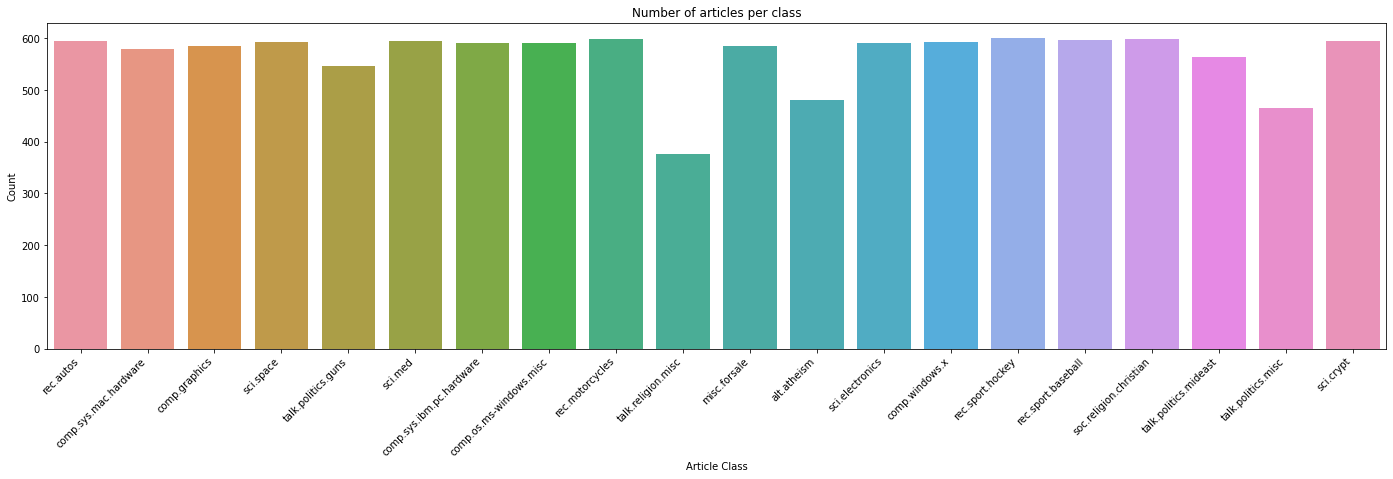

In [6]:
plt.figure(figsize=(24,6))
ax = sns.countplot(x='news_class', data=X_train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Number of articles per class', fontsize='large')
plt.ylabel('Count')
plt.xlabel('Article Class')
plt.show()

By simple considering words in the text split by empty spaces, we can find the average number of words in each of the articles.

The distributions seems to be right skewed for all types of articles, with sports related articles being the longest.

In [7]:
X_train_df['article_len'] = X_train_df['news'].apply(lambda x: len(x.split(' ')))

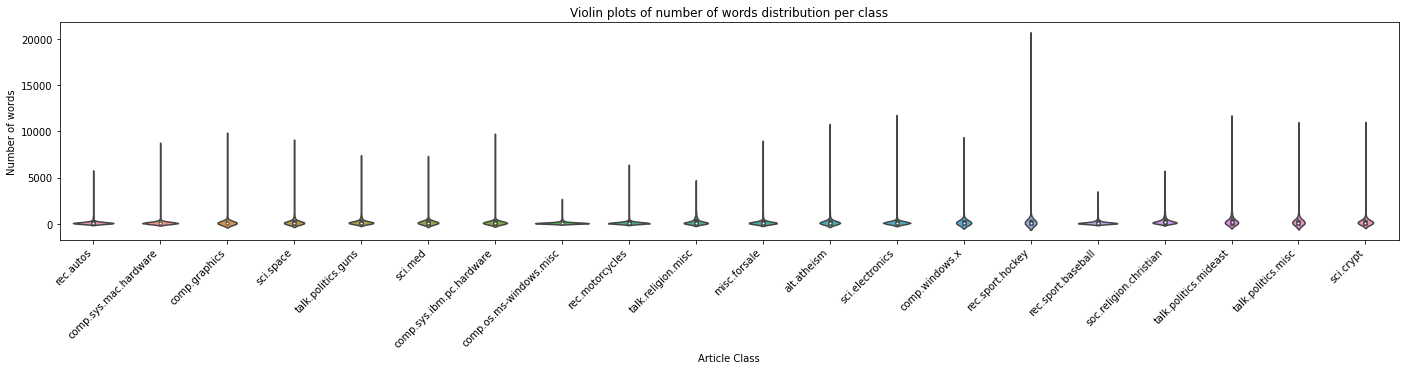

In [8]:
plt.figure(figsize=(24,4))
ax = sns.violinplot(x='news_class', y='article_len', data=X_train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Violin plots of number of words distribution per class', fontsize='large')
plt.ylabel('Number of words')
plt.xlabel('Article Class')
plt.show()

In [9]:
text_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

# fit the model
text_clf.fit(X_train.data, X_train.target)

# make predictions
predictions = text_clf.predict(X_test.data)

print(f"Weighted F1 classification score is: {round(f1_score(X_test.target, predictions, average='weighted')*100, 2)}%")

Weighted F1 classification score is: 60.54%


In [10]:
clf_report = classification_report(X_test.target, predictions, target_names=X_test.target_names, output_dict=True)

In [11]:
pd.DataFrame(clf_report)

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,...,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc,accuracy,macro avg,weighted avg
precision,0.814815,0.721557,0.702128,0.553471,0.811847,0.827195,0.862620,0.820669,0.889286,0.948276,...,0.859589,0.837838,0.220468,0.587912,0.853896,0.806452,0.500000,0.606213,0.722197,0.724466
recall,0.068966,0.619537,0.502538,0.752551,0.605195,0.739241,0.692308,0.681818,0.625628,0.692695,...,0.633838,0.629442,0.947236,0.587912,0.699468,0.080645,0.003984,0.606213,0.584285,0.606213
f1-score,0.127168,0.666667,0.585799,0.637838,0.693452,0.780749,0.768137,0.744828,0.734513,0.800582,...,0.729651,0.718841,0.357685,0.587912,0.769006,0.146628,0.007905,0.606213,0.585435,0.605355
support,319.000000,389.000000,394.000000,392.000000,385.000000,395.000000,390.000000,396.000000,398.000000,397.000000,...,396.000000,394.000000,398.000000,364.000000,376.000000,310.000000,251.000000,0.606213,7532.000000,7532.000000


In [12]:
confusion_data = confusion_matrix(X_test.target, predictions)

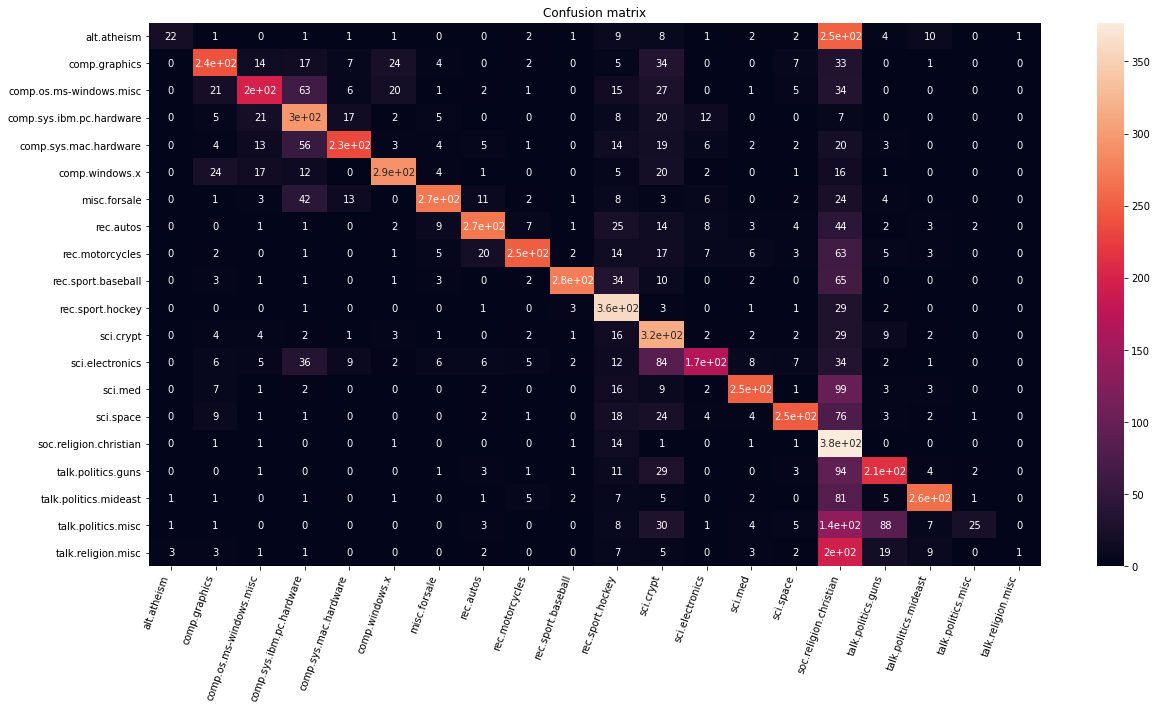

In [13]:
labels = X_test.target_names
plt.figure(figsize=(20,10))
ax = sns.heatmap(confusion_data, annot=True, annot_kws={'size':10})
ax.set_xticklabels(labels, rotation=70, ha='right')
ax.set_yticklabels(labels, rotation=0, ha='right')
plt.title('Confusion matrix', fontsize='large')
plt.show()

Trying different architectures

In [14]:
text_clf = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer(use_idf=False)),
                     ('clf', MultinomialNB())
                    ])

# fit the model
text_clf.fit(X_train.data, X_train.target)

# make predictions
predictions = text_clf.predict(X_test.data)

print(f"Weighted F1 classification score is: {round(f1_score(X_test.target, predictions, average='weighted')*100, 2)}%")

Weighted F1 classification score is: 48.99%


In [15]:
text_clf = Pipeline([('count_vectorizer', CountVectorizer()),
                     ('clf', MultinomialNB())
                    ])

# fit the model
text_clf.fit(X_train.data, X_train.target)

# make predictions
predictions = text_clf.predict(X_test.data)

print(f"Weighted F1 classification score is: {round(f1_score(X_test.target, predictions, average='weighted')*100, 2)}%")

Weighted F1 classification score is: 52.56%


Text processing 

In [16]:
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

def process_text(txt, wordnet_lemmatizer=wordnet_lemmatizer, stop=stop):
    processed_txt = txt.replace("\r", " ")
    processed_txt = processed_txt.replace("\n", " ")
    # "quotes"
    processed_txt = processed_txt.replace('"', '')
    # pronouns --> Anastasia's
    processed_txt = processed_txt.replace("'s", "")
    # punctuation 
    processed_txt = re.sub(r'[^\w\s]', '', processed_txt)
    # lowercase 
    processed_txt = processed_txt.lower()
    # extra spacing 
    processed_txt = processed_txt.replace("  ", " ")

    # lemmatize
    processed_txt = [wordnet_lemmatizer.lemmatize(word) for word in processed_txt.split(' ')]
    # remove stopwords
    processed_txt = ' '.join([word for word in processed_txt if word not in stop])

    return processed_txt

In [17]:
X_train_df['processed_news'] = X_train_df['news'].apply(process_text)

X_test_df = pd.DataFrame(X_test.data)
X_test_df.columns=['news']
X_test_df['news_id'] = X_test.target

X_test_df['processed_news'] = X_test_df['news'].apply(process_text)

In [18]:
text_clf = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                     ('clf', MultinomialNB())
                    ])

# fit the model
text_clf.fit(X_train_df['processed_news'], X_train_df['news_id'])

# make predictions
predictions = text_clf.predict(X_test_df['processed_news'])

print(f"Weighted F1 classification score is: {round(f1_score(X_test_df['news_id'], predictions, average='weighted')*100, 2)}%")

Weighted F1 classification score is: 65.08%


The scores have improved. I am adding a grid search for the best parameters for TF-IDF and Multinomial Naive Bayes to find the best hyperparameters.

In [22]:
grid_params = {
    'tfidf_vectorizer__use_idf': (True, False),
    'tfidf_vectorizer__min_df': [3, 4, 5],
    'tfidf_vectorizer__max_df': [0.7, 0.8, 0.9],
    'tfidf_vectorizer__ngram_range':((1,1), (1,2), (2,2)),
    'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1] 
}

text_clf = Pipeline([
            ('tfidf_vectorizer', TfidfVectorizer()),
            ('clf', MultinomialNB())
           ])

grid = GridSearchCV(text_clf, param_grid=grid_params, cv=5, refit=True, verbose=10)
grid.fit(X_train_df['processed_news'], X_train_df['news_id'])

tfidf_vectorizer__max_df=0.9, tfidf_vectorizer__min_df=3, tfidf_vectorizer__ngram_range=(2, 2), tfidf_vectorizer__use_idf=False 
[CV]  clf__alpha=1.1, tfidf_vectorizer__max_df=0.9, tfidf_vectorizer__min_df=3, tfidf_vectorizer__ngram_range=(2, 2), tfidf_vectorizer__use_idf=False, score=0.492, total=   2.6s
[CV] clf__alpha=1.1, tfidf_vectorizer__max_df=0.9, tfidf_vectorizer__min_df=4, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1.1, tfidf_vectorizer__max_df=0.9, tfidf_vectorizer__min_df=4, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__use_idf=True, score=0.704, total=   1.2s
[CV] clf__alpha=1.1, tfidf_vectorizer__max_df=0.9, tfidf_vectorizer__min_df=4, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__use_idf=True 
[CV]  clf__alpha=1.1, tfidf_vectorizer__max_df=0.9, tfidf_vectorizer__min_df=4, tfidf_vectorizer__ngram_range=(1, 1), tfidf_vectorizer__use_idf=True, score=0.693, total=   1.2s
[CV] clf__alpha=1.1, tfidf_vectorizer__ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3,
                                        0.5, 0.7, 0.9, 1.1],
                         'tfidf_vectorizer__max_df': [0.7, 0.8, 0.9],
                         'tfidf_vectorizer__min_df': [3, 4, 5],
                         'tfidf_vectorizer__ngram_range': ((1, 1), (1, 2),
                                                           (2, 2)),
                         'tfidf_vectorizer__use_idf': (True, False)},
             verbose=10)

In [23]:
print(f'Best hyperparameters for the text classification pipeline are {grid.best_params_}')

Best hyperparameters for the text classification pipeline are {'clf__alpha': 0.03, 'tfidf_vectorizer__max_df': 0.7, 'tfidf_vectorizer__min_df': 3, 'tfidf_vectorizer__ngram_range': (1, 1), 'tfidf_vectorizer__use_idf': True}


Weighted F1 classification score is: 69.23%




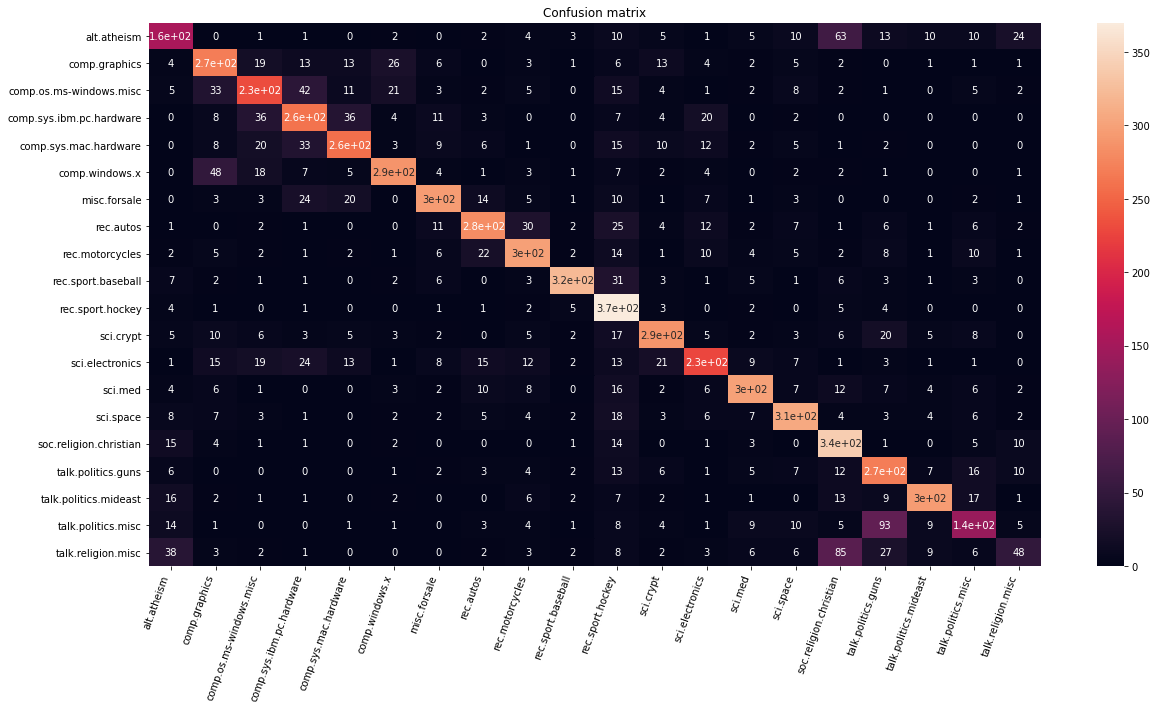

In [26]:
# pipeline with optimal parameters
text_clf = Pipeline([('tfidf_vectorizer', TfidfVectorizer(
                                            use_idf=True, 
                                            min_df=3, 
                                            max_df=0.7, 
                                            ngram_range=(1,1))),
                     ('clf', MultinomialNB(alpha=0.03))
                    ])

# fit the model
text_clf.fit(X_train_df['processed_news'], X_train_df['news_id'])

# make predictions
predictions = text_clf.predict(X_test_df['processed_news'])

print(f"Weighted F1 classification score is: {round(f1_score(X_test_df['news_id'], predictions, average='weighted')*100, 2)}%\n\n")

# generate the new plot
confusion_data = confusion_matrix(X_test_df['news_id'], predictions)

labels = X_test.target_names
plt.figure(figsize=(20,10))
ax = sns.heatmap(confusion_data, annot=True, annot_kws={'size':10})
ax.set_xticklabels(labels, rotation=70, ha='right')
ax.set_yticklabels(labels, rotation=0, ha='right')
plt.title('Confusion matrix', fontsize='large')
plt.show()